# Downloading spatial data via API request
In this notebook, I will keep track of the central mechanics of how to access the spatial data necessary for running the model, using API requests.

Let's decide on a given point in Sweden defined by it's coordinated in SWEREF99 TM

In [1]:
#target_point = [535301,6307813]
target_point = [582280,7108041]


Our next step is to define an area centered in this point with a fixed size. We define the `image_size` (size of the selected area) in number of pixels and the resolution `meters_per_pixel`:

In [2]:
image_size = 256
meters_per_pixel = 10

Here is a function that returns the edge coordinates of a square window centered in a given point:

In [3]:
def get_window_coordinates(target_point, offset=150):
    coordinates = [target_point[0]-offset, target_point[1]-offset, target_point[0]+offset, target_point[1]+offset] 
    return coordinates
    

Now we will use this function, defining the appropriate offset (distance to each corner of the box from center point).

In [4]:
offset = (image_size / 2) * meters_per_pixel
coordinates_list = get_window_coordinates(target_point, offset)
coordinates_list

[581000.0, 7106761.0, 583560.0, 7109321.0]

In [5]:
coordinates_list

[581000.0, 7106761.0, 583560.0, 7109321.0]

The server with the remote sensing data can be found under this url: https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt.
When clicking on the link you can explore which data products are available.

### Tree height
For the purpose of this tutorial we will focus on tree-height, which is called 'Tradhojd' and can be found [here](https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Tradhojd/ImageServer).

Define the parameters of the http API request.

In [6]:
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"SKS_Tradhojd_rod"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson'
)

Now we need to define the target URL from where the data shall be extracted. This is going to be the following:

In [7]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Samverkan/Tradhojd/ImageServer/exportImage'
#url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Tradhojd_3_1/ImageServer/exportImage'

Now let us make the request. We need a user-name and password to get access to the data, which can be requested at Oppnadata@skogsstyrelsen.se

In [8]:
import getpass
username = getpass.getpass()

In [9]:
password = getpass.getpass()

Below we define a function that will produce a download link for a specifically requested tiff file, provided a url (`url`), a set of parameters (`params`), the user-name (`username`) and password (`password`).

In [10]:
def get_image_url(url, params, username, password):
    # When making get image requests, use HTTP POST to not risk "URL too long" errors,
    # see https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/414
    post_headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(url, params=params, auth=(username, password), headers=post_headers)
    # Requests built in error check for status code
    response.raise_for_status()
    # Read the json data from response
    json_response = response.json()
    # Extra error check, ArcGis can return HTTP Status 200 but still fail, then we have to check the error object
    if "error" in json_response:
        error = json_response.get("error")
        raise Exception(f"Request failed with error: {error.get('message')}")
    if 'href' not in json_response:
        raise Exception("No image url returned")
    # Extract the image path on the server
    image_href = json_response['href']
    return image_href

In [11]:
import os, shutil, requests
image_href = get_image_url(url, params, username, password)
image_href

'https://geodata.skogsstyrelsen.se/arcgis/rest/directories/arcgisoutput/Samverkan/Tradhojd_ImageServer/_ags_6a81b1b7_d5e4_4d9b_9074_47c6711a5c13.tif'

Now we use the download link to download the tiff image to file, provided a specific destination output file name (`image_path`):

In [12]:
def download_tif_image(image_href, username, password, image_path='input.tif'):
    response = requests.get(image_href, auth=(username, password), stream=True)
    # Check if the response is OK
    if response.status_code != 200:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")
    # Ensure the content type is TIFF
    if 'image/tiff' not in response.headers.get('Content-Type', ''):
        raise Exception("The downloaded file is not a TIFF image")
    # Ensure complete download
    content_length = response.headers.get('Content-Length')
    if content_length is not None:
        total_bytes = int(content_length)
        if total_bytes != len(response.content):
            raise Exception("Incomplete download of the TIFF image")
    # Create image dir if not exists
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    # Write the image bytes to disk
    with open(image_path, 'wb') as f:
        f.write(response.content)


In [13]:
outpath = 'geodata_tiffs/treeheight.tiff'
download_tif_image(image_href, username, password, outpath)

Or do it all in one function:

In [14]:
def get_and_save_image(url, params, username, password, image_path):
    # When making get image requests, use HTTP POST to not risk "URL too long" errors,
    # see https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/414
    post_headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(url, params=params, auth=(username, password), headers=post_headers)
    # Requests built in error check for status code
    response.raise_for_status()
    # Read the json data from response
    json_response = response.json()
    # Extra error check, ArcGis can return HTTP Status 200 but still fail, then we have to check the error object
    if "error" in json_response:
        error = json_response.get("error")
        raise Exception(f"Request failed with error: {error.get('message')}")
    if 'href' not in json_response:
        raise Exception("No image url returned")

    # Extract the image path on the server
    image_href = json_response['href']

    # Make request to get the image bytes
    img_bytes = requests.get(image_href, auth=(username, password), stream=True)

    # Save the image to disk
    try:
        # Create image dir if not exists
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        # Read and write the image bytes to disk
        with open(image_path, 'wb') as f:
            img_bytes.raw.decode_content = True
            shutil.copyfileobj(img_bytes.raw, f)
    except Exception as e:
        raise Exception(f"Error when saving image to file {image_path}. Shutil Error: {e}")
    
outpath = 'geodata_tiffs/treeheight.tiff'
get_and_save_image(url, params, username, password, outpath)

Now we have the treeheight data downloaded for the target area. Let's have a look at the downloaded tiff file:

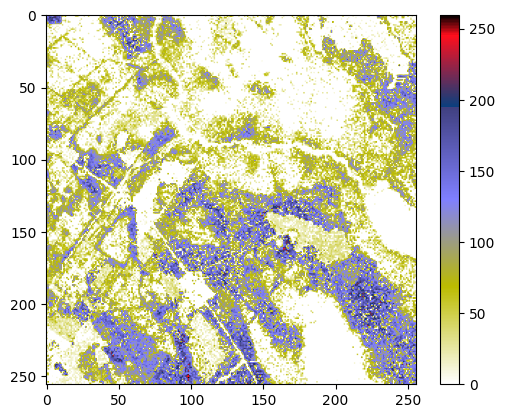

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tifffile import imsave, imread

## Create a custom colormap
#colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
#cmap_name = "green_yellow_red"
#cm = LinearSegmentedColormap.from_list(cmap_name, colors)

image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
#plt.axis('off')  # To hide axis values
plt.show()

Another way of downloading the same data is by sending the request embedded in a link. The resulting link showing the data can be loaded in a webbrowser.

In [16]:
import numpy as np
result = f"{url}?bbox=%27{np.round(coordinates_list[0])}%2C+{np.round(coordinates_list[1])}%2C+{np.round(coordinates_list[2])}%2C+{np.round(coordinates_list[3])}%27&bboxSR=&size=&imageSR=&time=&format=jpgpng&pixelType=S16&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=+RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=&renderingRule=&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image"
result

'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Samverkan/Tradhojd/ImageServer/exportImage?bbox=%27581000.0%2C+7106761.0%2C+583560.0%2C+7109321.0%27&bboxSR=&size=&imageSR=&time=&format=jpgpng&pixelType=S16&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=+RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=&renderingRule=&adjustAspectRatio=true&validateExtent=false&lercVersion=1&compressionTolerance=&f=image'

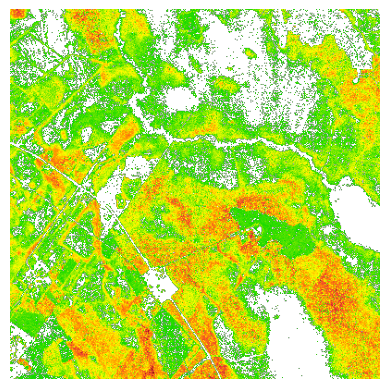

In [17]:
import requests
from PIL import Image
from io import BytesIO

try:
    response = requests.get(result, params=params, auth=(username, password))
    response.raise_for_status()  # This will raise an HTTPError if the HTTP request returned an unsuccessful status code.

    # Open the image
    image = Image.open(BytesIO(response.content))
    #image.show()  # This will display the image using an image viewer on your system.

except requests.exceptions.RequestException as e:
    print(f"Error: {e}")

plt.imshow(image)
#plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

In [18]:
#coordinates_list=[408164, 6307006, 409444, 6308286]
result="%s/0/query?bbox='%i,+%i,+%i,+%i'&outFields=*"%(url,coordinates_list[0],coordinates_list[1],coordinates_list[2],coordinates_list[3])
result
#urllib.request.urlretrieve(result,'test.html')

"https://geodata.skogsstyrelsen.se/arcgis/rest/services/Samverkan/Tradhojd/ImageServer/exportImage/0/query?bbox='581000,+7106761,+583560,+7109321'&outFields=*"

Now let's do the same with some of the other available data layers.
### Sattelite image

In [19]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Satellitdata_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
#    renderingRule='{"rasterfunction":"SvartVit"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='0',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson'
)

(256, 256)


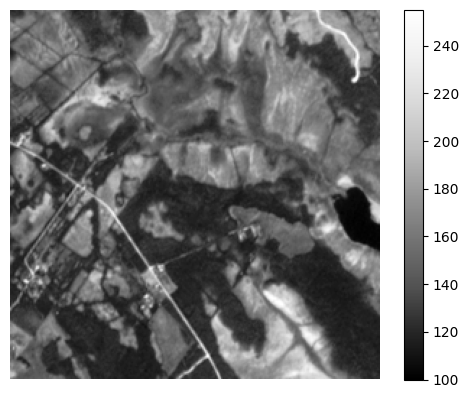

In [20]:
outpath = 'geodata_tiffs/satellite.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)

print(image.shape)
plt.imshow(image,cmap='Greys_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

There are multiple different bands and time-points available for the satellite data. Here we download the RGB image for the year 2022:

(256, 256)


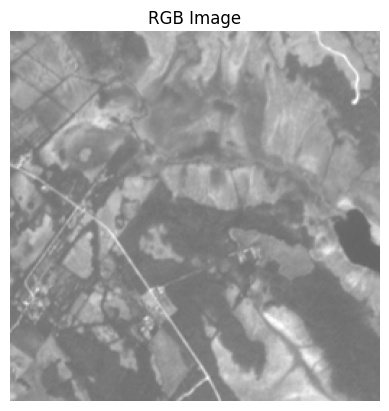

In [20]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Satellitdata_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"Satellitdata2022"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='0',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson'
)
from PIL import Image
import matplotlib.pyplot as plt

print(image.shape)
# Open the TIFF file
with Image.open(outpath) as img:
    # Convert the image to RGB (in case it's not in this mode)
    rgb_img = img.convert('RGB')
    # Plot the image
    plt.imshow(rgb_img)
    plt.title('RGB Image')
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()

And yet another available raster-function that transforms the satellite data into segmented images:

(256, 256, 3)


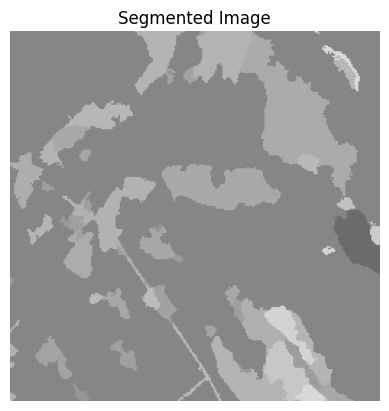

In [21]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Satellitdata_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"Segmentering"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='0',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson'
)
outpath = 'geodata_tiffs/satellite.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)

print(image.shape)
# Open the TIFF file
with Image.open(outpath) as img:
    # Convert the image to RGB (in case it's not in this mode)
    rgb_img = img.convert('RGB')
    # Plot the image
    plt.imshow(rgb_img)
    plt.title('Segmented Image')
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()

### Soil moisture

In [22]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Markfuktighet_SLU_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='0',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson'
)

(256, 256)


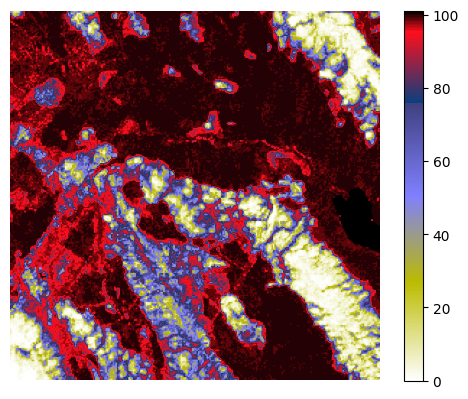

In [23]:
outpath = 'geodata_tiffs/soilmoisture.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
print(image.shape)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Elevational gradient

In [24]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Lutning/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

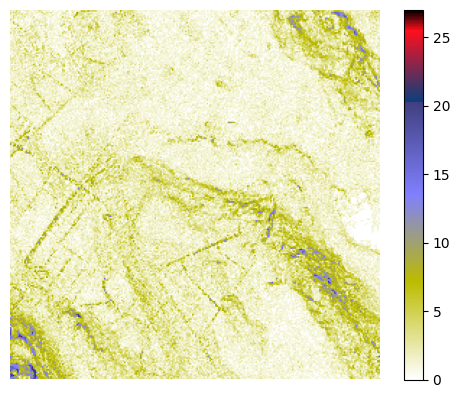

In [25]:
outpath = 'geodata_tiffs/elev_gradient.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Max. Temperature (in 2023)

In [26]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/CDS_Maxtemp_1_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

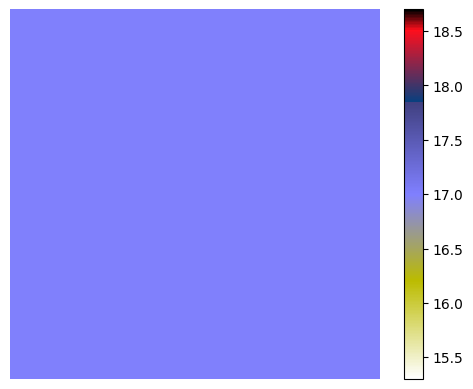

In [27]:
outpath = 'geodata_tiffs/maxtemp.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

The same data layer shows for a larger area, to see some variation:

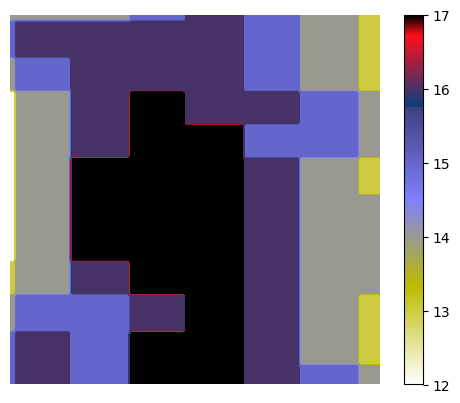

In [28]:
image_size = 10000
meters_per_pixel = 10
offset = (image_size / 2) * meters_per_pixel
coordinates_list = get_window_coordinates(target_point, offset)
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)
outpath = 'geodata_tiffs/maxtemp_large.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Summed (accumulated) temperature through year (2023)

In [29]:
image_size = 256
meters_per_pixel = 10
offset = (image_size / 2) * meters_per_pixel
coordinates_list = get_window_coordinates(target_point, offset)

url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/CDS_Tempsum_1_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

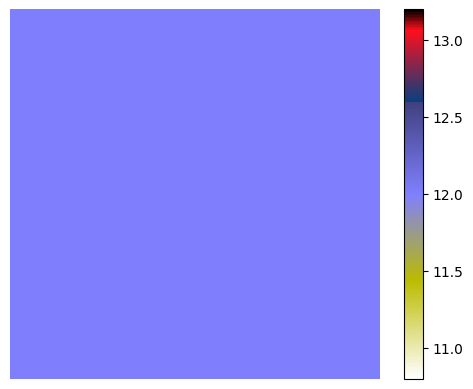

In [30]:
outpath = 'geodata_tiffs/sumtemp.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Presence of ditches in forest or fields

In [31]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Diken_1_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

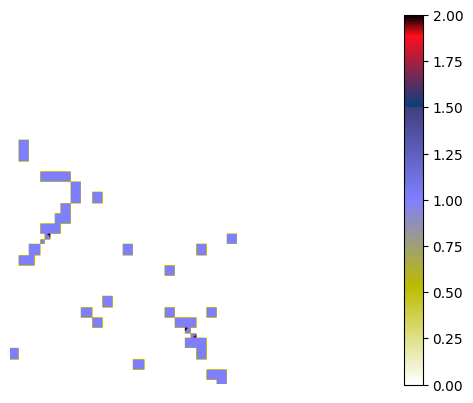

In [32]:
outpath = 'geodata_tiffs/ditches.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Peat depth and soil type

In [33]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Skogsdatalabbet/Torvkarta_1_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

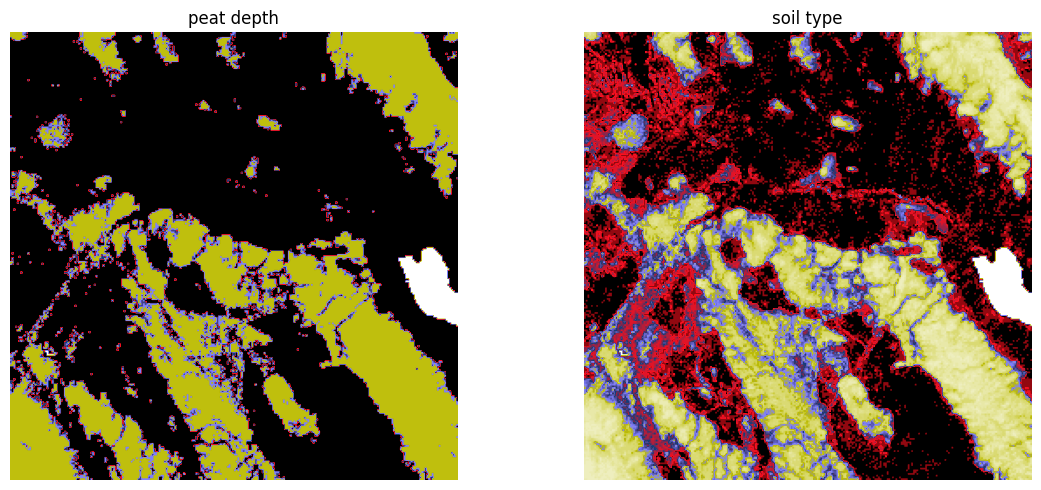

In [34]:
outpath = 'geodata_tiffs/soil.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
names = ['peat depth', 'soil type']
cmaps=['gist_stern_r','gist_stern_r']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for i, ax in enumerate(axes):
    ax.imshow(image[...,i], cmap=cmaps[i])  # Change 'gray' to any colormap you like
    ax.set_title(names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Skogsdatalabbet/Torvkarta_1_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"SKS_Torv"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)


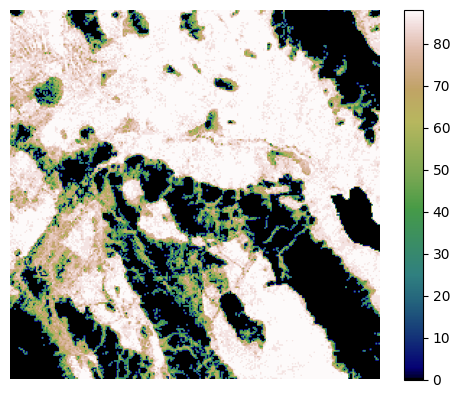

In [36]:
outpath = 'geodata_tiffs/peat_depth.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_earth')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Basic forest attributes
This dataset was released by the Swedish Forest Agency (Skogsstyrelsen) and contains 8 different channels:
Basic forest attributes (Skogliga grunddata):
- Volym (band 1)
- Medelhöjd (band 2)
- Grundyta (band 3)
- Medeldiameter (band 4)
- Biomassa (band 5)
- p95 (band 6)
- Vegkvot (band 7)
- UnixDate (band 8)

In [37]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/SkogligaGrunddata/ImageServer/exportImage'
#url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/SkogligaGrunddata_3_1/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)


In [38]:
outpath = 'geodata_tiffs/forest_attributes.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
image.shape

(256, 256, 8)

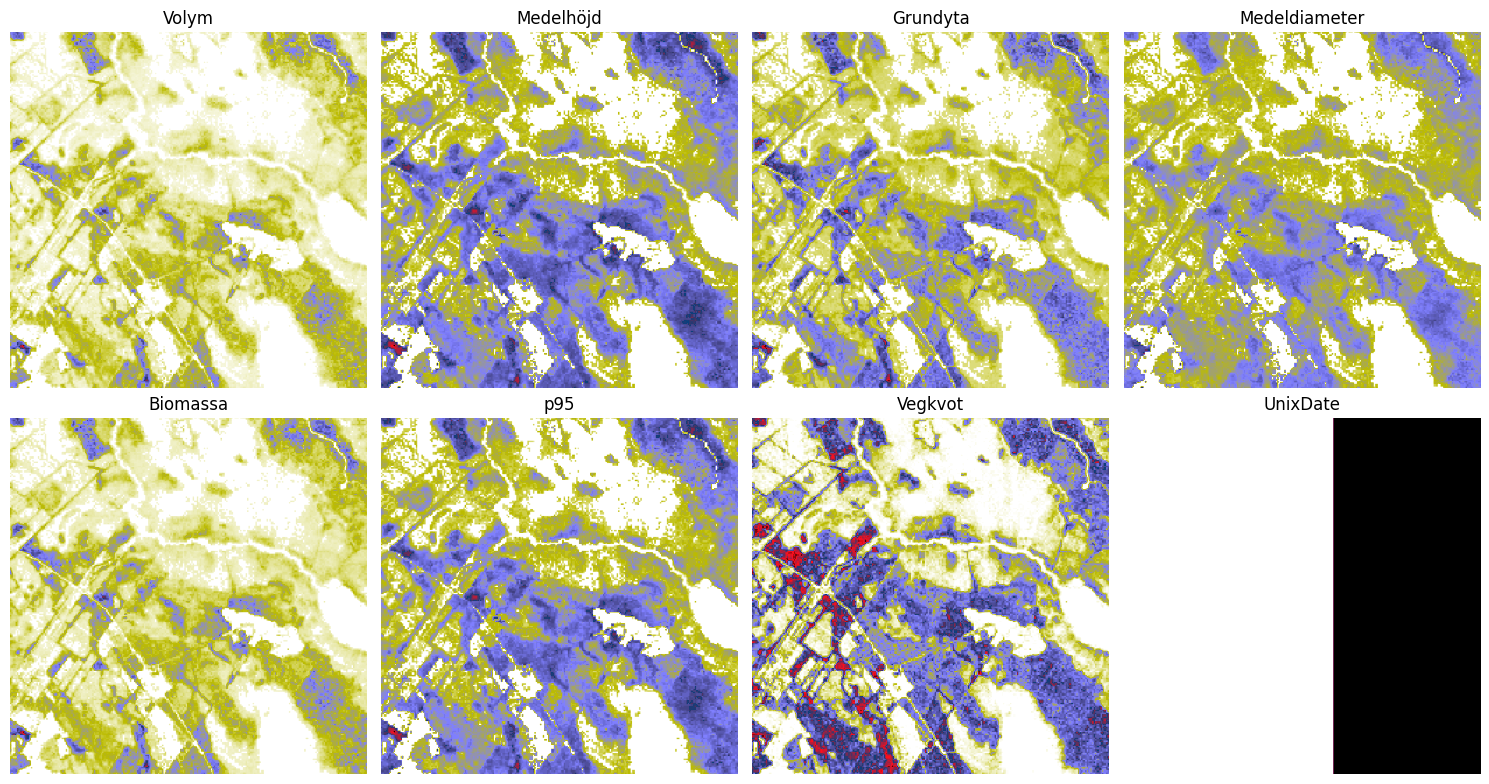

In [39]:
# Plot each channel
names = ['Volym', 'Medelhöjd', 'Grundyta', 'Medeldiameter', 'Biomassa', 'p95', 'Vegkvot', 'UnixDate']
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 2 rows, 4 columns
for i, ax in enumerate(axes.ravel()):
    ax.imshow(image[..., i], cmap='gist_stern_r')  # Change 'gray' to any colormap you like
    ax.axis('off')
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

The last channel shows the date that the laserscanning data was recorded, which forms the basis of all of these data products. A more useful unit way of expressing temporal information in this context is to know whether or not there were leaves on the trees during the time of the laserscanning, which is expected to affect estimates on e.g. biomass etc. This information can be calculated from these data, using the `SKS_LovAvlov` raster function:

In [40]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/SkogligaGrunddata/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"SKS_LovAvlov"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

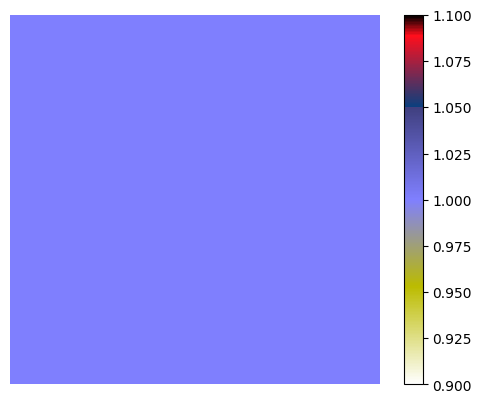

In [41]:
outpath = 'geodata_tiffs/leaves_present.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_stern_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

### Marktäckedata

In [42]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Marktackedata_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

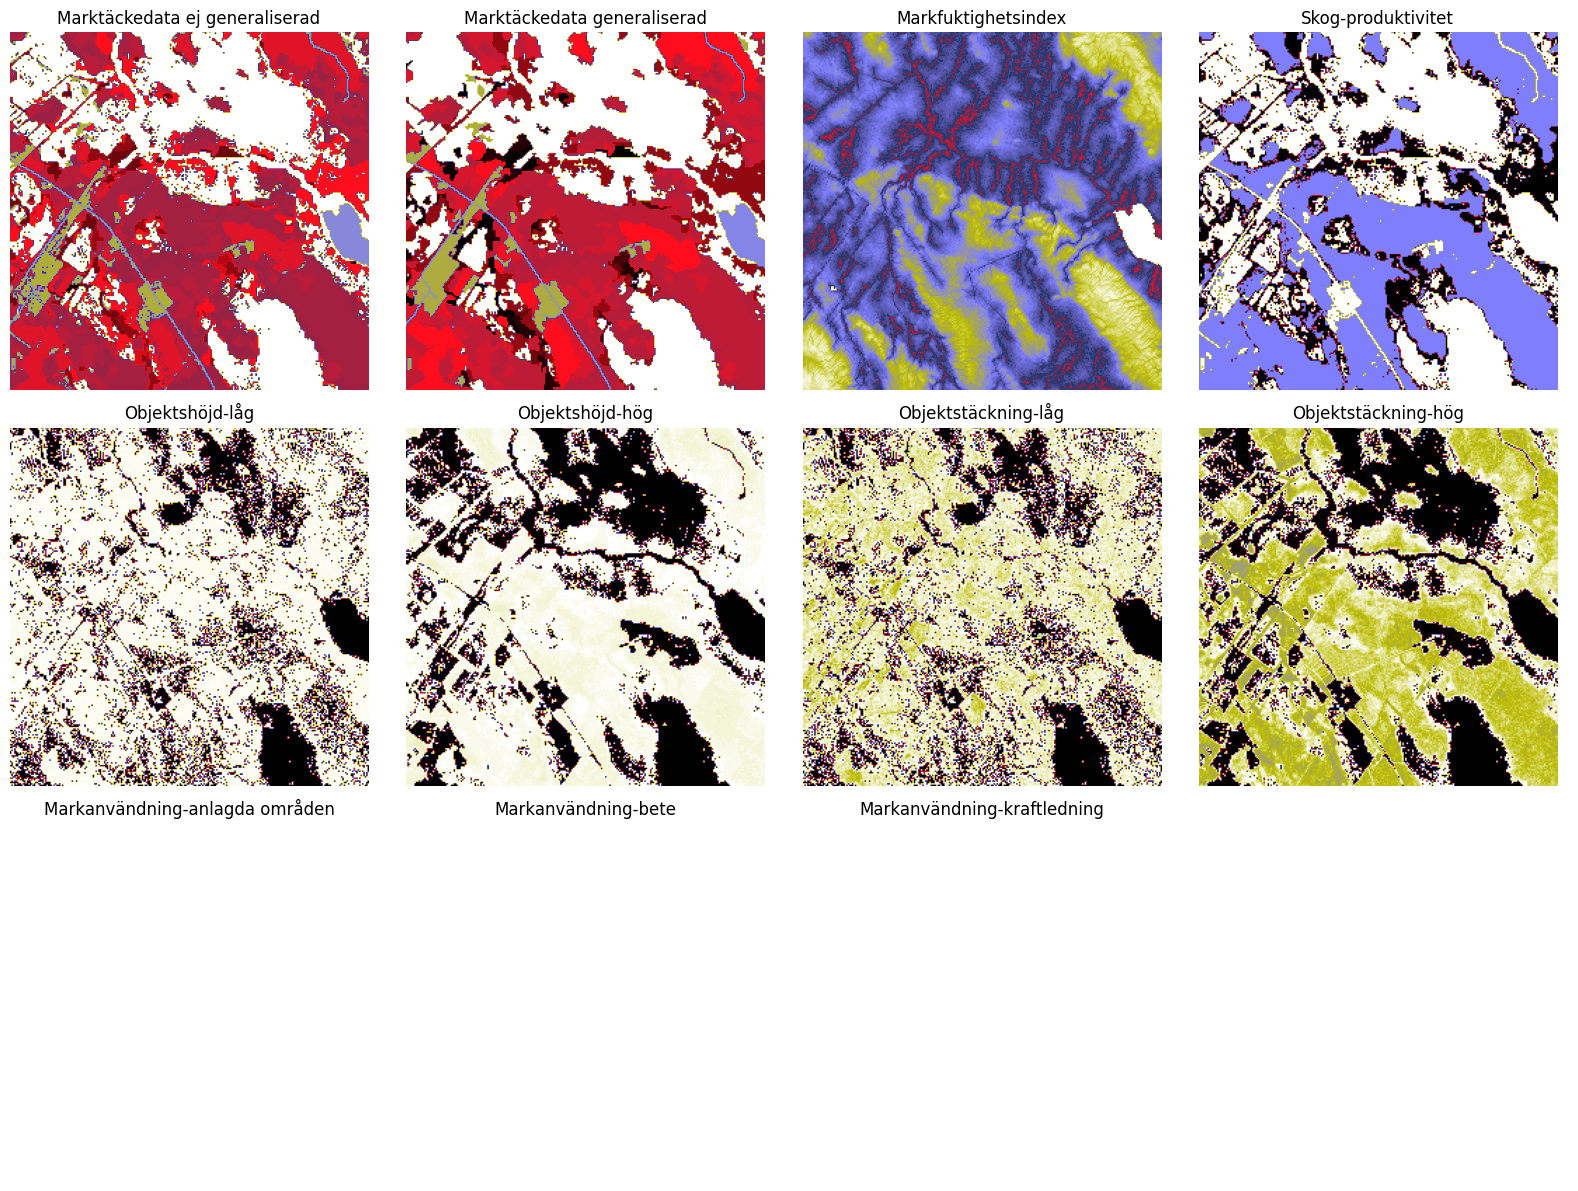

In [43]:
outpath = 'geodata_tiffs/nmd.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
names = ['Marktäckedata ej generaliserad', 'Marktäckedata generaliserad', 'Markfuktighetsindex', 'Skog-produktivitet', 'Objektshöjd-låg', 'Objektshöjd-hög', 'Objektstäckning-låg', 'Objektstäckning-hög', 'Markanvändning-anlagda områden', 'Markanvändning-bete', 'Markanvändning-kraftledning']
# Plot each channel
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # 3 rows, 4 columns

for i, ax in enumerate(axes.ravel()):
    if i < 11:  # Only display for the first 11 subplots
        ax.imshow(image[..., i], cmap='gist_stern_r')  # Change 'gray' to any colormap you like
        ax.set_title(names[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

The most interesting channel is the first one, which shows the categorical data of the NMD dataset. Let's plot only that channel, but with a different color-scale:

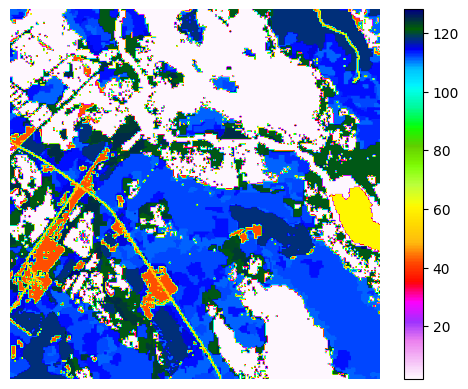

In [44]:
image = imread(outpath)
plt.imshow(image[..., 0], cmap='gist_ncar_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

In [45]:
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/Marktackedata_2_0/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"SKS_NMD_ogeneraliserad"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)

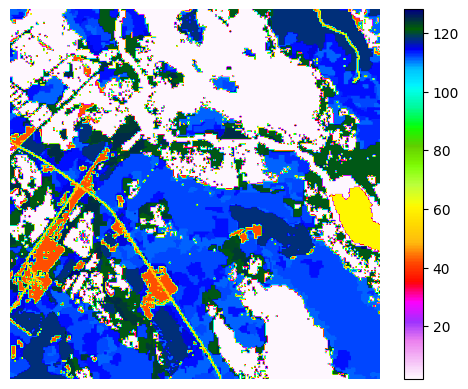

In [46]:
outpath = 'geodata_tiffs/nmd_only_1st_channel.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_ncar_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

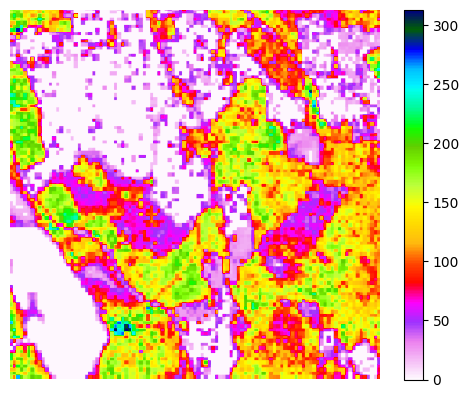

In [27]:
coordinates_list=[526466,6642549,527746,6643829]
url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/SkogligaGrunddata/ImageServer/exportImage'
#url = 'https://geodata.skogsstyrelsen.se/arcgis/rest/services/Publikt/SkogligaGrunddata_3_1/ImageServer/exportImage'
params = dict(
    bbox='{},+{},+{},+{}'.format(coordinates_list[0], coordinates_list[1], coordinates_list[2], coordinates_list[3]),
    bboxSR='3006',
    size='{},{}'.format(image_size,image_size),
    imageSR='',
    time='',
    format='tiff',
    pixelType='UNKNOWN',
    noData='',
    noDataInterpretation='esriNoDataMatchAny',
    interpolation='+RSP_BilinearInterpolation',
    renderingRule='{"rasterfunction":"Biomassa0"}',
    compression='LZ77',
    compressionQuality='',
    bandIds='',
    sliceId='',
    adjustAspectRatio='true',
    validateExtent='false',
    lercVersion='1',
    compressionTolerance='',
    f='pjson',
)
outpath = 'geodata_tiffs/forest_attributes.tiff'
get_and_save_image(url, params, username, password, outpath)
image = imread(outpath)
plt.imshow(image, cmap='gist_ncar_r')
plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

In [ ]:
python download_prediction_geodata.py \
  --coordinates "522626,6642549,528626,6648549" \
  --offset 1480 \
  --image_size 148 \
  --download_folder "data/prediction_geodata/download_folder" \
  --configuration "version_public_sat" \
  --meters_per_pixel 10 \
  --image_scale 1 \
  --additional_offset -200 \
  --target_server "https://geodata.skogsstyrelsen.se/arcgis/rest/" \
  --username "uppun_user" \
  --password "4sjHa2YQ" \
  --threads 10 \
  --sweden_map 'data/sweden_polygon/Sweref_99_TM/shape/swemap_gpkg/swemap.gpkg' \
  --auto_adjust_prediction_range



In [56]:
import torch
import torchvision.models as models

# Example: Load a pretrained model (replace with your model)
model = models.resnet18(pretrained=True)

# Print the model architecture
print(model)


/Users/toban562/miniconda3/envs/bioscann/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/toban562/miniconda3/envs/bioscann/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/toban562/miniconda3/envs/bioscann/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/toban562/miniconda3/envs/bioscann/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weigh

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

ImportError: cannot import name 'summary' from 'torch' (/Users/toban562/miniconda3/envs/bioscann/lib/python3.8/site-packages/torch/__init__.py)